Bayesian Zig Zag
===

Developing probabilistic models using grid methods and MCMC.

Thanks to Chris Fonnesback for his help with this example, and to Colin Carroll, who added features to pymc3 to support some of these examples.

To install the most current version of pymc3 from source, run

```
pip3 install -U git+https://github.com/pymc-devs/pymc3.git
```

Copyright 2018 Allen Downey

MIT License: https://opensource.org/licenses/MIT

In [1]:
from __future__ import print_function, division

%matplotlib inline
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

import numpy as np
import pymc3 as pm

import matplotlib.pyplot as plt

/home/jonah/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Simulating hockey

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, `lambda`, in goals per game.

For the first example, we'll assume that `lambda` is known (somehow) to be 2.7.  Since regulation play (as opposed to overtime) is 60 minutes, we can compute the goal scoring rate per minute.

In [2]:
lam_per_game = 2.7
min_per_game = 60
lam_per_min = lam_per_game / min_per_game
lam_per_min, lam_per_min**2

(0.045000000000000005, 0.0020250000000000003)

If we assume that a goal is equally likely during any minute of the game, and we ignore the possibility of scoring more than one goal in the same minute, we can simulate a game by generating one random value each minute.

In [9]:
np.random.random(min_per_game)

array([0.10917445, 0.04845644, 0.6668992 , 0.56477727, 0.56146559,
       0.55280064, 0.16327401, 0.81599155, 0.47987076, 0.92049123,
       0.49394019, 0.25349978, 0.06788623, 0.32738827, 0.24168115,
       0.36032676, 0.69211714, 0.2079908 , 0.64229629, 0.81810977,
       0.06961261, 0.19222875, 0.98246908, 0.09361316, 0.99203742,
       0.98078355, 0.50090089, 0.80353801, 0.89133207, 0.41936905,
       0.48084474, 0.22568694, 0.26171487, 0.32114773, 0.40614323,
       0.26911526, 0.57484054, 0.39397639, 0.2009361 , 0.41901969,
       0.0351586 , 0.46471214, 0.96159809, 0.48493884, 0.50348239,
       0.88759482, 0.95176001, 0.04154464, 0.92370544, 0.67540858,
       0.22483789, 0.92976997, 0.20965824, 0.11261612, 0.60836896,
       0.07867308, 0.73386724, 0.13846122, 0.53311902, 0.28618119])

If the random value is less than `lam_per_min`, that means we score a goal during that minute.

In [10]:
np.random.random(min_per_game) < lam_per_min

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False])

So we can get the number of goals scored by one team like this:

In [11]:
np.sum(np.random.random(min_per_game) < lam_per_min)

4

I'll wrap that in a function.

In [12]:
def half_game(lam_per_min, min_per_game=60):
    return np.sum(np.random.random(min_per_game) < lam_per_min)

And simulate 10 games.

In [13]:
size = 10
sample = [half_game(lam_per_min) for i in range(size)]

[0, 4, 2, 4, 2, 1, 3, 2, 2, 2]

If we simulate 1000 games, we can see what the distribution looks like.  The average of this sample should be close to `lam_per_game`.

In [16]:
size = 1000
sample_sim = [half_game(lam_per_min) for i in range(size)]
np.mean(sample_sim), lam_per_game

(2.698, 2.7)

## PMFs

To visualize distributions, I'll start with a probability mass function (PMF), which I'll implement using a `Counter`.



In [17]:
from collections import Counter

class Pmf(Counter):
    
    def normalize(self):
        """Normalizes the PMF so the probabilities add to 1."""
        total = sum(self.values())
        for key in self:
            self[key] /= total
            
    def sorted_items(self):
        """Returns the outcomes and their probabilities."""
        return zip(*sorted(self.items()))

Here are some functions for plotting PMFs.

In [18]:
plot_options = dict(linewidth=3, alpha=0.6)

def underride(options):
    """Add key-value pairs to d only if key is not in d.

    options: dictionary
    """

    for key, val in plot_options.items():
        options.setdefault(key, val)
    return options

def plot(xs, ys, **options):
    """Line plot with plot_options."""
    plt.plot(xs, ys, **underride(options))

def bar(xs, ys, **options):
    """Bar plot with plot_options."""
    plt.bar(xs, ys, **underride(options))

def plot_pmf(sample, **options):
    """Compute and plot a PMF."""
    pmf = Pmf(sample)
    pmf.normalize()
    xs, ps = pmf.sorted_items()
    bar(xs, ps, **options)
    
def pmf_goals():
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel('PMF')
    plt.title('Distribution of goals scored')
    legend()
    
def legend(**options):
    """Draw a legend only if there are labeled items.
    """
    ax = plt.gca()
    handles, labels = ax.get_legend_handles_labels()
    if len(labels):
        plt.legend(**options)

Here's what the results from the simulation look like.

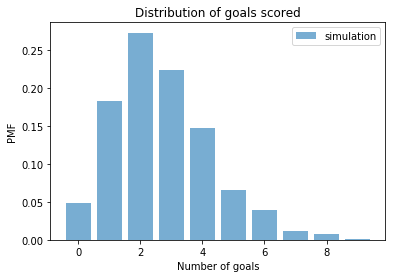

In [19]:
plot_pmf(sample_sim, label='simulation')
pmf_goals()

## Analytic distributions

For the simulation we just did, we can figure out the distribution analytically: it's a binomial distribution with parameters `n` and `p`, where `n` is the number of minutes and `p` is the probability of scoring a goal during any minute.

We can use NumPy to generate a sample from a binomial distribution.

In [20]:
n = min_per_game
p = lam_per_min
sample_bin = np.random.binomial(n, p, size)
np.mean(sample_bin)

2.691

And confirm that the results are similar to what we got from the model.

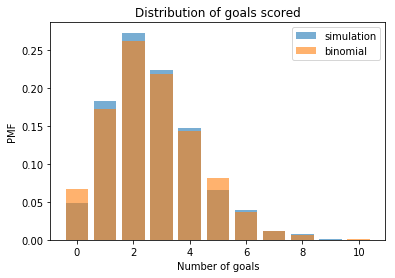

In [21]:
plot_pmf(sample_sim, label='simulation')
plot_pmf(sample_bin, label='binomial')
pmf_goals()

But plotting PMFs is a bad way to compare distributions.  It's better to use the cumulative distribution function (CDF).

In [22]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = Pmf(sample)
    xs, freqs = pmf.sorted_items()
    ps = np.cumsum(freqs, dtype=np.float)
    ps /= ps[-1]
    plot(xs, ps, **options)
    
def cdf_rates():
    """Decorate the axes."""
    plt.xlabel('Goal scoring rate (mu)')
    plt.ylabel('CDF')
    plt.title('Distribution of goal scoring rate')
    legend()

def cdf_goals():
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel('CDF')
    plt.title('Distribution of goals scored')
    legend()

def plot_cdfs(*sample_seq, **options):
    """Plot multiple CDFs."""
    for sample in sample_seq:
        plot_cdf(sample, **options)
    cdf_goals()

Now we can compare the results from the simulation and the sample from the biomial distribution.

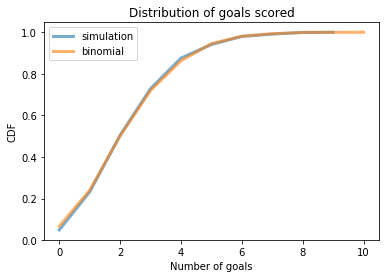

In [24]:
plot_cdf(sample_sim, label='simulation')
plot_cdf(sample_bin, label='binomial')
cdf_goals()

## Poisson process

For large values of `n`, the binomial distribution converges to the Poisson distribution with parameter `mu = n * p`, which is also `mu = lam_per_game`.

In [29]:
mu = lam_per_game
sample_poisson = np.random.poisson(mu, size)
np.mean(sample_poisson)

2.73

And we can confirm that the results are consistent with the simulation and the binomial distribution.

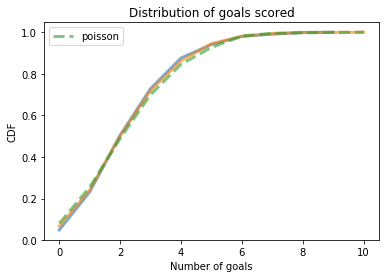

In [30]:
plot_cdfs(sample_sim, sample_bin)
plot_cdf(sample_poisson, label='poisson', linestyle='dashed')
legend()

## Warming up PyMC

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [31]:
model = pm.Model()

with model:
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

In [32]:
len(trace['goals'])

1000

In [33]:
sample_pm = trace['goals']
np.mean(sample_pm)

2.601

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

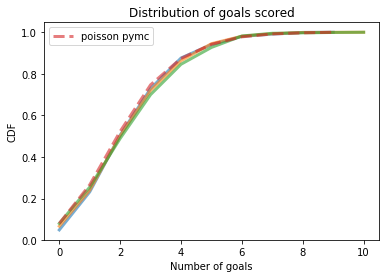

In [34]:
plot_cdfs(sample_sim, sample_bin, sample_poisson)
plot_cdf(sample_pm, label='poisson pymc', linestyle='dashed')
legend()

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its CDF and PMF analytically.  We can use the CDF to check, one more time, the previous results.

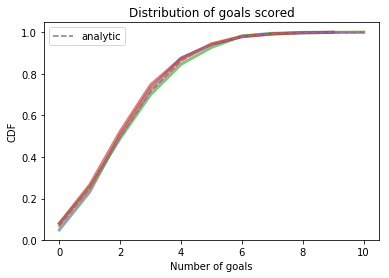

In [35]:
import scipy.stats as st

xs = np.arange(11)
ps = st.poisson.cdf(xs, mu)

plot_cdfs(sample_sim, sample_bin, sample_poisson, sample_pm)
plt.plot(xs, ps, label='analytic', linestyle='dashed')
legend()

And we can use the PMF to compute the probability of any given outcome.  Here's what the analytic PMF looks like:

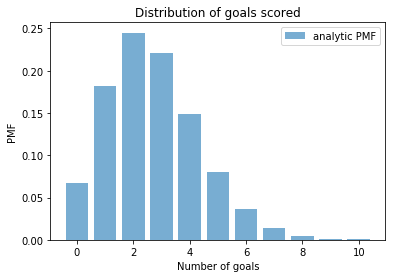

In [36]:
xs = np.arange(11)
ps = st.poisson.pmf(xs, mu)
bar(xs, ps, label='analytic PMF')
pmf_goals()

And here's a function that compute the probability of scoring a given number of goals in a game, for a known value of `mu`.

In [37]:
def poisson_likelihood(goals, mu):
    """Probability of goals given scoring rate.
    
    goals: observed number of goals (scalar or sequence)
    mu: hypothetical goals per game
    
    returns: probability
    """
    return np.prod(st.poisson.pmf(goals, mu))

Here's the probability of scoring 6 goals in a game if the long-term rate is 2.7 goals per game.

In [38]:
poisson_likelihood(goals=6, mu=2.7)

0.036162211957124435

Here's the probability of scoring 3 goals.

In [39]:
poisson_likelihood(goals=3, mu=2.7)

0.22046768454274915

This function also works with a sequence of goals, so we can compute the probability of scoring 6 goals in the first game and 3 in the second.

In [40]:
poisson_likelihood(goals=[6, 2], mu=2.7)

0.008858443486812598

## Bayesian inference with grid approximation

Ok, it's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

The following class implements Bayes's theorem.

In [41]:
class Suite(Pmf):
    """Represents a set of hypotheses and their probabilities."""
    
    def bayes_update(self, data, like_func):
        """Perform a Bayesian update.
        
        data:      some representation of observed data
        like_func: likelihood function that takes (data, hypo), where
                   hypo is the hypothetical value of some parameter,
                   and returns P(data | hypo)
        """
        for hypo in self:
            self[hypo] *= like_func(data, hypo)
        self.normalize()
        
    def plot(self, **options):
        """Plot the hypotheses and their probabilities."""
        xs, ps = self.sorted_items()
        plot(xs, ps, **options)
        

def pdf_rate():
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel('PDF')
    plt.title('Distribution of goal scoring rate')
    legend()

I'll start with a uniform prior just to keep things simple.  We'll choose a better prior later.

In [42]:
hypo_mu = np.linspace(0, 20, num=51)
hypo_mu

array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ,
        4.4,  4.8,  5.2,  5.6,  6. ,  6.4,  6.8,  7.2,  7.6,  8. ,  8.4,
        8.8,  9.2,  9.6, 10. , 10.4, 10.8, 11.2, 11.6, 12. , 12.4, 12.8,
       13.2, 13.6, 14. , 14.4, 14.8, 15.2, 15.6, 16. , 16.4, 16.8, 17.2,
       17.6, 18. , 18.4, 18.8, 19.2, 19.6, 20. ])

Initially `suite` represents the prior distribution of `mu`.

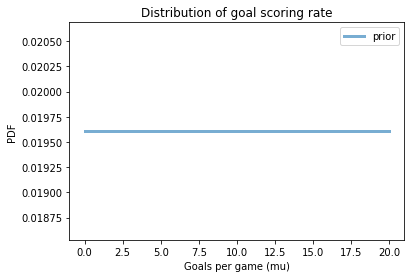

In [44]:
suite = Suite(hypo_mu)
suite.normalize()
suite.plot(label='prior')
pdf_rate()

Now we can update it with the data and plot the posterior.

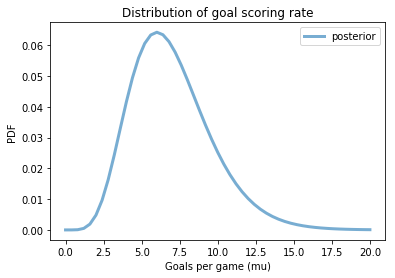

In [45]:
suite.bayes_update(data=6, like_func=poisson_likelihood)
suite.plot(label='posterior')
pdf_rate()

With a uniform prior, the posterior is the likelihood function, and the MAP is the value of `mu` that maximizes likelihood, which is the observed number of goals, 6.

This result is probably not reasonable, because the prior was not reasonable.

## A better prior

To construct a better prior, I'll use scores from previous Stanley Cup finals to estimate the parameters of a gamma distribution.

Why gamma?  You'll see.

Here are (total goals)/(number of games) for both teams from 2013 to 2017, not including games that went into overtime. 

In [46]:
xs = [13/6, 19/6, 8/4, 4/4, 10/6, 13/6, 2/2, 4/2, 5/3, 6/3]

[2.1666666666666665,
 3.1666666666666665,
 2.0,
 1.0,
 1.6666666666666667,
 2.1666666666666665,
 1.0,
 2.0,
 1.6666666666666667,
 2.0]

If those values were sampled from a gamma distribution, we can estimate its parameters, `k` and `theta`.

In [47]:
def estimate_gamma_params(xs):
    """Estimate the parameters of a gamma distribution.
    
    See https://en.wikipedia.org/wiki/Gamma_distribution#Parameter_estimation
    """
    s = np.log(np.mean(xs)) - np.mean(np.log(xs))
    k = (3 - s + np.sqrt((s-3)**2 + 24*s)) / 12 / s
    theta = np.mean(xs) / k
    alpha = k
    beta = 1 / theta
    return alpha, beta

Here are the estimates.

In [48]:
alpha, beta = estimate_gamma_params(xs)
print(alpha, beta)

9.590040427964036 5.092056864405683


The following function takes `alpha` and `beta` and returns a "frozen" distribution from SciPy's stats module:

In [49]:
def make_gamma_dist(alpha, beta):
    """Returns a frozen distribution with given parameters.
    """
    return st.gamma(a=alpha, scale=1/beta)

The frozen distribution knows how to compute its mean and standard deviation:

In [50]:
dist = make_gamma_dist(alpha, beta)
print(dist.mean(), dist.std())

1.883333333333333 0.6081587702831356


And it can compute its PDF.

In [51]:
hypo_mu = np.linspace(0, 10, num=101)
ps = dist.pdf(hypo_mu)

array([0.00000000e+00, 6.38558824e-08, 1.47882071e-05, 2.89335244e-04,
       2.05818741e-03, 8.41008968e-03, 2.42005653e-02, 5.46708620e-02,
       1.03457950e-01, 1.71009756e-01, 2.54058869e-01, 3.46221457e-01,
       4.39353435e-01, 5.25141940e-01, 5.96484573e-01, 6.48394461e-01,
       6.78362677e-01, 6.86251605e-01, 6.73866305e-01, 6.44365210e-01,
       6.01647333e-01, 5.49811363e-01, 4.92738384e-01, 4.33813676e-01,
       3.75777888e-01, 3.20683656e-01, 2.69928462e-01, 2.24335393e-01,
       1.84257838e-01, 1.49689963e-01, 1.20370713e-01, 9.58741574e-02,
       7.56829865e-02, 5.92447692e-02, 4.60123559e-02, 3.54707493e-02,
       2.71531125e-02, 2.06485333e-02, 1.56038850e-02, 1.17217339e-02,
       8.75583226e-03, 6.50534975e-03, 4.80865843e-03, 3.53721739e-03,
       2.58989044e-03, 1.88787645e-03, 1.37032322e-03, 9.90624353e-04,
       7.13355115e-04, 5.11779658e-04, 3.65852616e-04, 2.60637420e-04,
       1.85068625e-04, 1.30993248e-04, 9.24350534e-05, 6.50346646e-05,
      

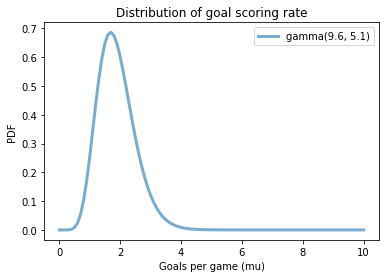

In [52]:
plot(hypo_mu, ps, label='gamma(9.6, 5.1)')
pdf_rate()

We can use `make_gamma_dist` to construct a prior suite with the given parameters.

In [53]:
def make_gamma_suite(xs, alpha, beta):
    """Makes a suite based on a gamma distribution.
    
    xs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: Suite
    """
    dist = make_gamma_dist(alpha, beta)
    ps = dist.pdf(xs)
    prior = Suite(dict(zip(xs, ps)))
    prior.normalize()
    return prior

Here's what it looks like.

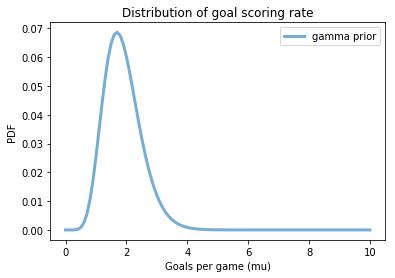

In [55]:
prior = make_gamma_suite(hypo_mu, alpha, beta)

prior.plot(label='gamma prior')
pdf_rate()

And we can update this prior using the observed data.

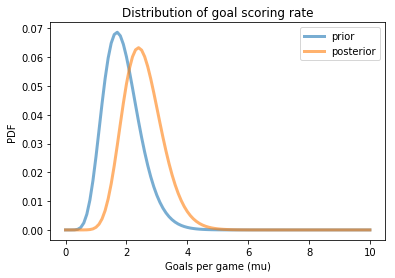

In [56]:
posterior = prior.copy()
posterior.bayes_update(data=6, like_func=poisson_likelihood)

prior.plot(label='prior')
posterior.plot(label='posterior')
pdf_rate()

The results are substantially different from what we got with the uniform prior.

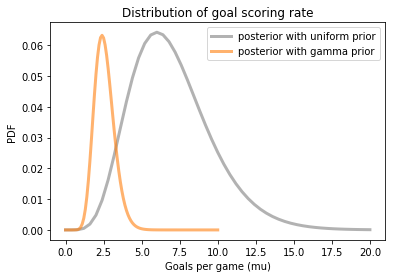

In [60]:
suite.plot(label='posterior with uniform prior', color='gray')
posterior.plot(label='posterior with gamma prior', color='C1')
pdf_rate()

Suppose the same team plays again and scores 2 goals in the second game.  We can perform a second update using the posterior from the first update as the prior for the second.

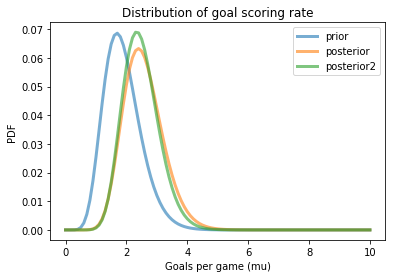

In [61]:
posterior2 = posterior.copy()
posterior2.bayes_update(data=2, like_func=poisson_likelihood)

prior.plot(label='prior')
posterior.plot(label='posterior')
posterior2.plot(label='posterior2')
pdf_rate()

Or, starting with the original prior, we can update with both pieces of data at the same time.

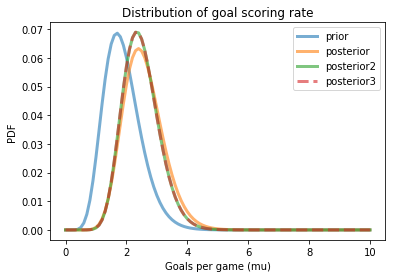

In [62]:
posterior3 = prior.copy()
posterior3.bayes_update(data=[6, 2], like_func=poisson_likelihood)

prior.plot(label='prior')
posterior.plot(label='posterior')
posterior2.plot(label='posterior2')
posterior3.plot(label='posterior3', linestyle='dashed')
pdf_rate()

## Update using conjugate priors

I'm using a gamma distribution as a prior in part because it has a shape that seems credible based on what I know about hockey.

But it is also useful because it happens to be the conjugate prior of the Poisson distribution, which means that if the prior is gamma and we update with a Poisson likelihood function, the posterior is also gamma.

See https://en.wikipedia.org/wiki/Conjugate_prior#Discrete_distributions

And often we can compute the parameters of the posterior with very little computation.  If we observe `x` goals in `1` game, the new parameters are `alpha+x` and `beta+1`.

In [63]:
class GammaSuite:
    """Represents a gamma conjugate prior/posterior."""
    
    def __init__(self, alpha, beta):
        """Initialize.
        
        alpha, beta: parameters
        dist: frozen distribution from scipy.stats
        """
        self.alpha = alpha
        self.beta = beta
        self.dist = make_gamma_dist(alpha, beta)
    
    def plot(self, xs, **options):
        """Plot the suite.
        
        xs: locations where we should evaluate the PDF.
        """
        ps = self.dist.pdf(xs)
        ps /= np.sum(ps)
        plot(xs, ps, **options)
        
    def bayes_update(self, data):
        return GammaSuite(self.alpha+data, self.beta+1)

Here's what the prior looks like using a `GammaSuite`:

1.883333333333333

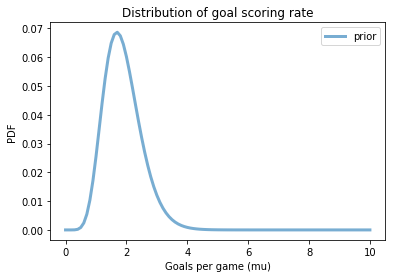

In [64]:
gamma_prior = GammaSuite(alpha, beta)
gamma_prior.plot(hypo_mu, label='prior')
pdf_rate()
gamma_prior.dist.mean()

And here's the posterior after one update.

2.559076642743212

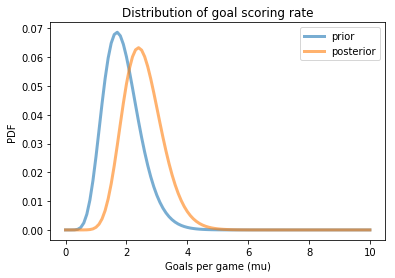

In [65]:
gamma_posterior = gamma_prior.bayes_update(6)

gamma_prior.plot(hypo_mu, label='prior')
gamma_posterior.plot(hypo_mu, label='posterior')
pdf_rate()
gamma_posterior.dist.mean()

And we can confirm that the posterior we get using the conjugate prior is the same as the one we got using a grid approximation.

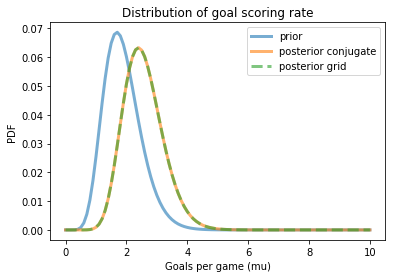

In [66]:
gamma_prior.plot(hypo_mu, label='prior')
gamma_posterior.plot(hypo_mu, label='posterior conjugate')
posterior.plot(label='posterior grid', linestyle='dashed')
pdf_rate()

## Posterior predictive distribution

Ok, let's get to what is usually the point of this whole exercise, making predictions.

The prior represents what we believe about the distribution of `mu` based on the data (and our prior beliefs).

Each value of `mu` is a possible goal scoring rate.

For a given value of `mu`, we can generate a distribution of goals scored in a particular game, which is Poisson.

But we don't have a given value of `mu`, we have a whole bunch of values for `mu`, with different probabilities.

So the posterior predictive distribution is a mixture of Poissons with different weights.

The simplest way to generate the posterior predictive distribution is to

1. Draw a random `mu` from the posterior distribution.

2. Draw a random number of goals from `Poisson(mu)`.

3. Repeat.

Here's a function that draws a sample from a posterior `Suite` (the grid approximation, not `GammaSuite`).

In [67]:
def sample_suite(suite, size):
    """Draw a random sample from a Suite
    
    suite: Suite object
    size: sample size
    """
    xs, ps = zip(*suite.items())
    return np.random.choice(xs, size, replace=True, p=ps)

Here's a sample of `mu` drawn from the posterior distribution (after one game).

In [68]:
size = 10000
sample_post = sample_suite(posterior, size)
np.mean(sample_post)

2.54788

Here's what the posterior distribution looks like.

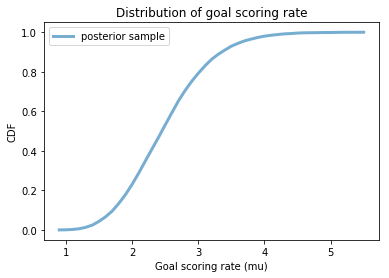

In [69]:
plot_cdf(sample_post, label='posterior sample')
cdf_rates()

Now for each value of `mu` in the posterior sample we draw one sample from `Poisson(mu)`

In [70]:
sample_post_pred = np.random.poisson(sample_post)
np.mean(sample_post_pred)

2.5756

Here's what the posterior predictive distribution looks like.

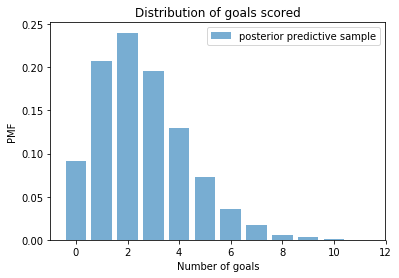

In [71]:
plot_pmf(sample_post_pred, label='posterior predictive sample')
pmf_goals()

## Posterior prediction done wrong

The posterior predictive distribution represents uncertainty from two sources:

1. We don't know `mu`

2. Even if we knew `mu`, we would not know the score of the next game.

It is tempting, but wrong, to generate a posterior prediction by taking the mean of the posterior distribution and drawing samples from `Poisson(mu)` with just a single value of `mu`.

That's wrong because it eliminates one of our sources of uncertainty.

Here's an example:

In [54]:
mu_mean = np.mean(sample_post)
sample_post_pred_wrong = np.random.poisson(mu_mean, size)
np.mean(sample_post_pred_wrong)

2.5447

Here's what the samples looks like:

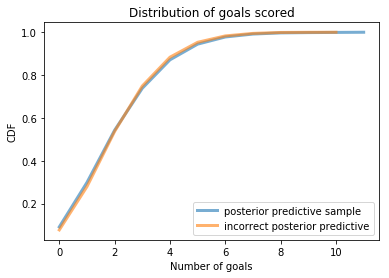

In [55]:
plot_cdf(sample_post_pred, label='posterior predictive sample')
plot_cdf(sample_post_pred_wrong, label='incorrect posterior predictive')
cdf_goals()

In the incorrect predictive sample, low values and high values are slightly less likely.

The means are about the same:

In [56]:
print(np.mean(sample_post_pred), np.mean(sample_post_pred_wrong))

2.5493 2.5447


But the standard deviation of the incorrect distribution is lower.

In [57]:
print(np.std(sample_post_pred), np.std(sample_post_pred_wrong))

1.70662518146194 1.6034967757996894


## Abusing PyMC

Ok, we are almost ready to use PyMC for its intended purpose, but first we are going to abuse it a little more.

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from the prior distribution of `mu`, with known `alpha` and `beta`.

We still have the values I estimated based on previous playoff finals:

In [72]:
print(alpha, beta)

9.590040427964036 5.092056864405683


Now we can draw a sample from the prior predictive distribution:

In [73]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

This might not be a sensible way to use PyMC.  If we just want to sample from the prior predictive distribution, we could use NumPy or SciPy just as well.  We're doing this to develop and test the model incrementally.

So let's see if the sample looks right.

In [74]:
sample_prior_pm = trace['mu']
np.mean(sample_prior_pm)

1.9014857683980049

In [75]:
sample_prior = sample_suite(prior, 2000)
np.mean(sample_prior)

1.8606500000000001

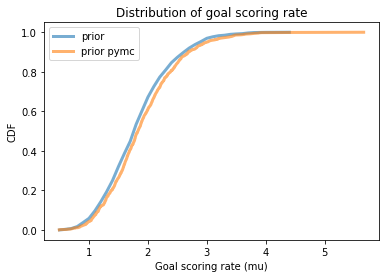

In [76]:
plot_cdf(sample_prior, label='prior')
plot_cdf(sample_prior_pm, label='prior pymc')
cdf_rates()

It looks pretty good (although not actually as close as I expected).

Now let's extend the model to sample from the prior predictive distribution.  This is still a silly way to do it, but it is one more step toward inference.

In [77]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[6])
    trace = pm.sample_prior_predictive(2000)

Let's see how the results compare with a sample from the prior predictive distribution, generated by plain old NumPy.

In [78]:
sample_prior_pred_pm = trace['goals'].flatten()
np.mean(sample_prior_pred_pm)

1.914

In [79]:
sample_prior_pred = np.random.poisson(sample_prior)
np.mean(sample_prior_pred)

1.888

Looks good.

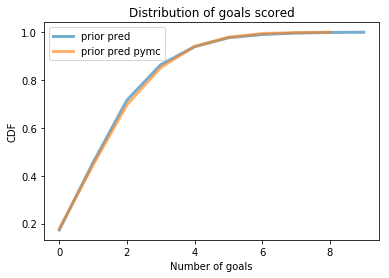

In [80]:
plot_cdf(sample_prior_pred, label='prior pred')
plot_cdf(sample_prior_pred_pm, label='prior pred pymc')
cdf_goals()

## Using PyMC

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `6`:

In [81]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=6)
    trace = pm.sample(2000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:02<00:00, 4459.34draws/s]


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

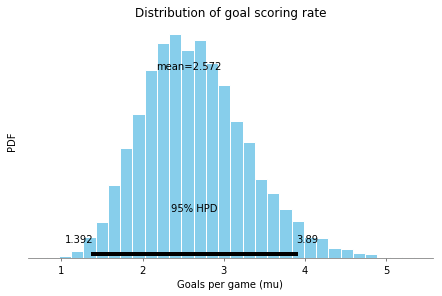

In [82]:
pm.plot_posterior(trace)
pdf_rate()

And we can extract a sample from the posterior of `mu`

In [87]:
sample_post_pm = trace['mu']
np.mean(sample_post_pm)

2.572279187145629

And compare it to the sample we drew from the grid approximation:

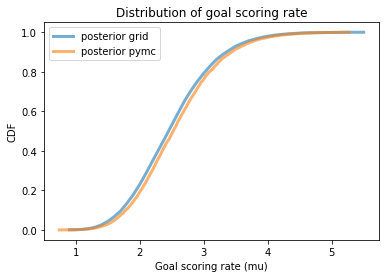

In [88]:
plot_cdf(sample_post, label='posterior grid')
plot_cdf(sample_post_pm, label='posterior pymc')
cdf_rates()

Again, it looks pretty good.

To generate a posterior predictive distribution, we can use `sample_ppc`

In [89]:
with model:
    post_pred = pm.sample_ppc(trace, samples=2000)

100%|██████████| 2000/2000 [00:00<00:00, 4999.82it/s]


Here's what it looks like:

In [90]:
sample_post_pred_pm = post_pred['goals']

array([6, 2, 1, ..., 5, 2, 2])

In [91]:
sample_post_pred_pm = post_pred['goals']
np.mean(sample_post_pred_pm)

2.558

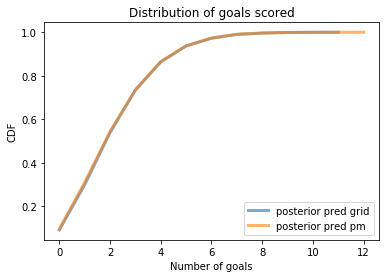

In [92]:
plot_cdf(sample_post_pred, label='posterior pred grid')
plot_cdf(sample_post_pred_pm, label='posterior pred pm')
cdf_goals()

Look's pretty good!

## Going hierarchical

So far, all of this is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

0.9916006779054446

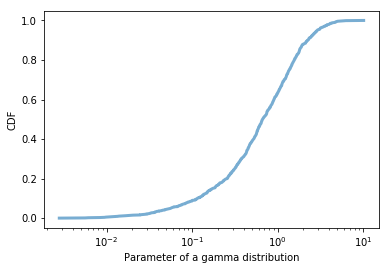

In [93]:
sample = pm.Exponential.dist(lam=1).random(size=1000)
plot_cdf(sample)
plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample)

This distribution represents radical uncertainty about the value of this distribution: it's probably between 0.1 and 10, but it could be really big or really small.

Here's a PyMC model that generates `alpha` and `beta` from an exponential distribution.

In [94]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    trace = pm.sample_prior_predictive(1000)

Here's what the distributions of `alpha` and `beta` look like.

0.9929284909210457

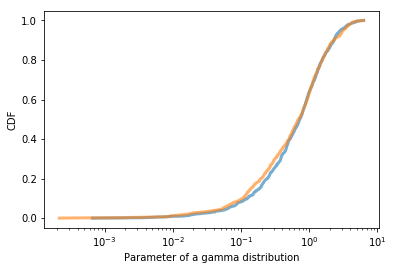

In [95]:
sample_prior_alpha = trace['alpha']
plot_cdf(sample_prior_alpha, label='alpha prior')
sample_prior_beta = trace['beta']
plot_cdf(sample_prior_beta, label='beta prior')

plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample_prior_alpha)

Now that we have `alpha` and `beta`, we can generate `mu`.

In [96]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

Here's what the prior distribution of `mu` looks like.

4.5198036264724335

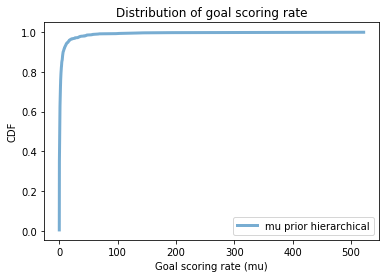

In [97]:
sample_prior_mu = trace['mu']
plot_cdf(sample_prior_mu, label='mu prior hierarchical')
cdf_rates()
np.mean(sample_prior_mu)

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."

If we zoom in on the range 0 to 10, we can compare the prior implied by the hierarchical model with the gamma prior I hand picked.

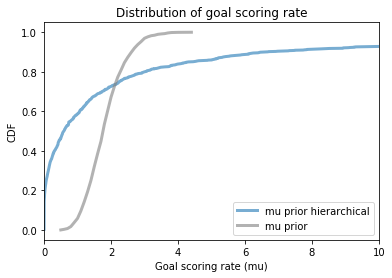

In [98]:
plot_cdf(sample_prior_mu, label='mu prior hierarchical')
plot_cdf(sample_prior, label='mu prior', color='gray')
plt.xlim(0, 10)
cdf_rates()

Obviously, they are very different.  They agree that the most likely values are less than 10, but the hierarchical model admits the possibility that `mu` could be orders of magnitude bigger.

Crazy as it sounds, that's probably what we want in a non-committal prior.

Ok, last step of the forward process, let's generate some goals.

In [99]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

Here's the prior predictive distribution of goals.

6.91

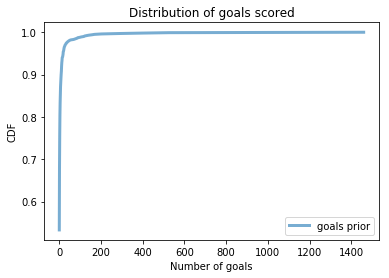

In [100]:
sample_prior_goals = trace['goals']
plot_cdf(sample_prior_goals, label='goals prior')
cdf_goals()
np.mean(sample_prior_goals)

To see whether that distribution is right, I ran samples using SciPy.

In [101]:
def forward_hierarchical(size=1):
    alpha = st.expon().rvs(size=size)
    beta = st.expon().rvs(size=size)
    mu = st.gamma(a=alpha, scale=1/beta).rvs(size=size)
    goals = st.poisson(mu).rvs(size=size)
    return goals[0]

sample_prior_goals_st = [forward_hierarchical() for i in range(1000)];

11.216

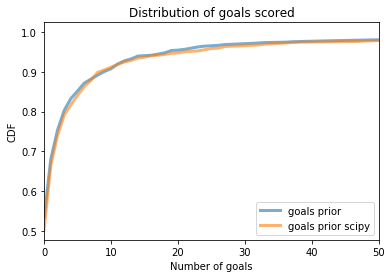

In [102]:
plot_cdf(sample_prior_goals, label='goals prior')
plot_cdf(sample_prior_goals_st, label='goals prior scipy')
cdf_goals()
plt.xlim(0, 50)
plt.legend(loc='lower right')
np.mean(sample_prior_goals_st)

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [103]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[6])
    trace = pm.sample(1000, tune=2000, nuts_kwargs=dict(target_accept=0.99))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:09<00:00, 1256.43draws/s]


Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

5.447281902998106

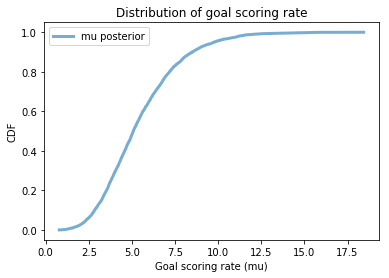

In [104]:
sample_post_mu = trace['mu']
plot_cdf(sample_post_mu, label='mu posterior')
cdf_rates()
np.mean(sample_post_mu)

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [105]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_VGK = pm.Gamma('mu_VGK', alpha, beta)
    mu_WSH = pm.Gamma('mu_WSH', alpha, beta)
    goals_VGK = pm.Poisson('goals_VGK', mu_VGK, observed=[6])
    goals_WSH = pm.Poisson('goals_WSH', mu_WSH, observed=[4])
    trace = pm.sample(1000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_WSH, mu_VGK, beta, alpha]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:08<00:00, 1446.96draws/s]


We can use `traceplot` to review the results and do some visual diagnostics.

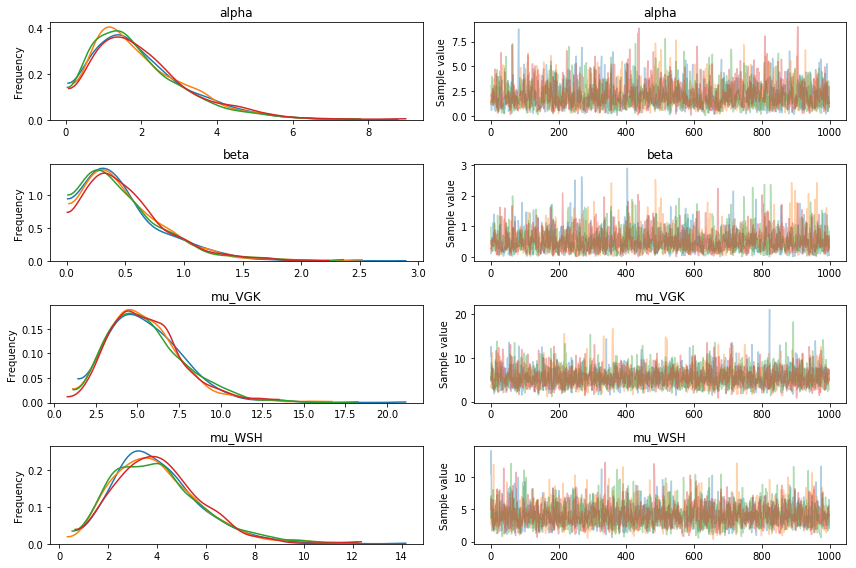

In [106]:
pm.traceplot(trace);

Here are the posterior distribitions for `mu_WSH` and `mu_VGK`.

(4.0273559918578625, 5.458780874512413)

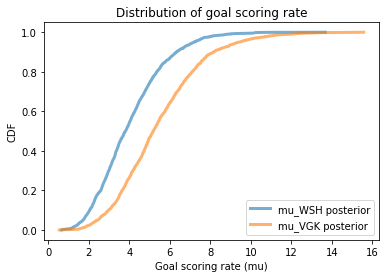

In [89]:
sample_post_mu_WSH = trace['mu_WSH']
plot_cdf(sample_post_mu_WSH, label='mu_WSH posterior')

sample_post_mu_VGK = trace['mu_VGK']
plot_cdf(sample_post_mu_VGK, label='mu_VGK posterior')

cdf_rates()
np.mean(sample_post_mu_WSH), np.mean(sample_post_mu_VGK)

On the basis of one game (and never having seen a previous game), here's the probability that Vegas is the better team.

In [90]:
np.mean(sample_post_mu_VGK > sample_post_mu_WSH)

0.7185

## More background

But let's take advantage of more information.  Here are the results from the five most recent Stanley Cup finals, ignoring games that went into overtime.

In [91]:
data = dict(BOS13 = [2, 1, 2],
            CHI13 = [0, 3, 3],
            NYR14 = [0, 2],
            LAK14 = [3, 1],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 4, 1],
            PIT16 = [3, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6,2,1],
            WSH18 = [4,3,3],
           )

{'BOS13': [2, 1, 2],
 'CHI13': [0, 3, 3],
 'NYR14': [0, 2],
 'LAK14': [3, 1],
 'TBL15': [1, 4, 3, 1, 1, 0],
 'CHI15': [2, 3, 2, 2, 2, 2],
 'SJS16': [2, 1, 4, 1],
 'PIT16': [3, 3, 2, 3],
 'NSH17': [3, 1, 5, 4, 0, 0],
 'PIT17': [5, 4, 1, 1, 6, 2],
 'VGK18': [6, 2, 1],
 'WSH18': [4, 3, 3]}

Here's how we can get the data into the model.

In [92]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(1000, tune=2000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]
Sampling 2 chains: 100%|██████████| 6000/6000 [00:20<00:00, 297.52draws/s]


And here are the results.

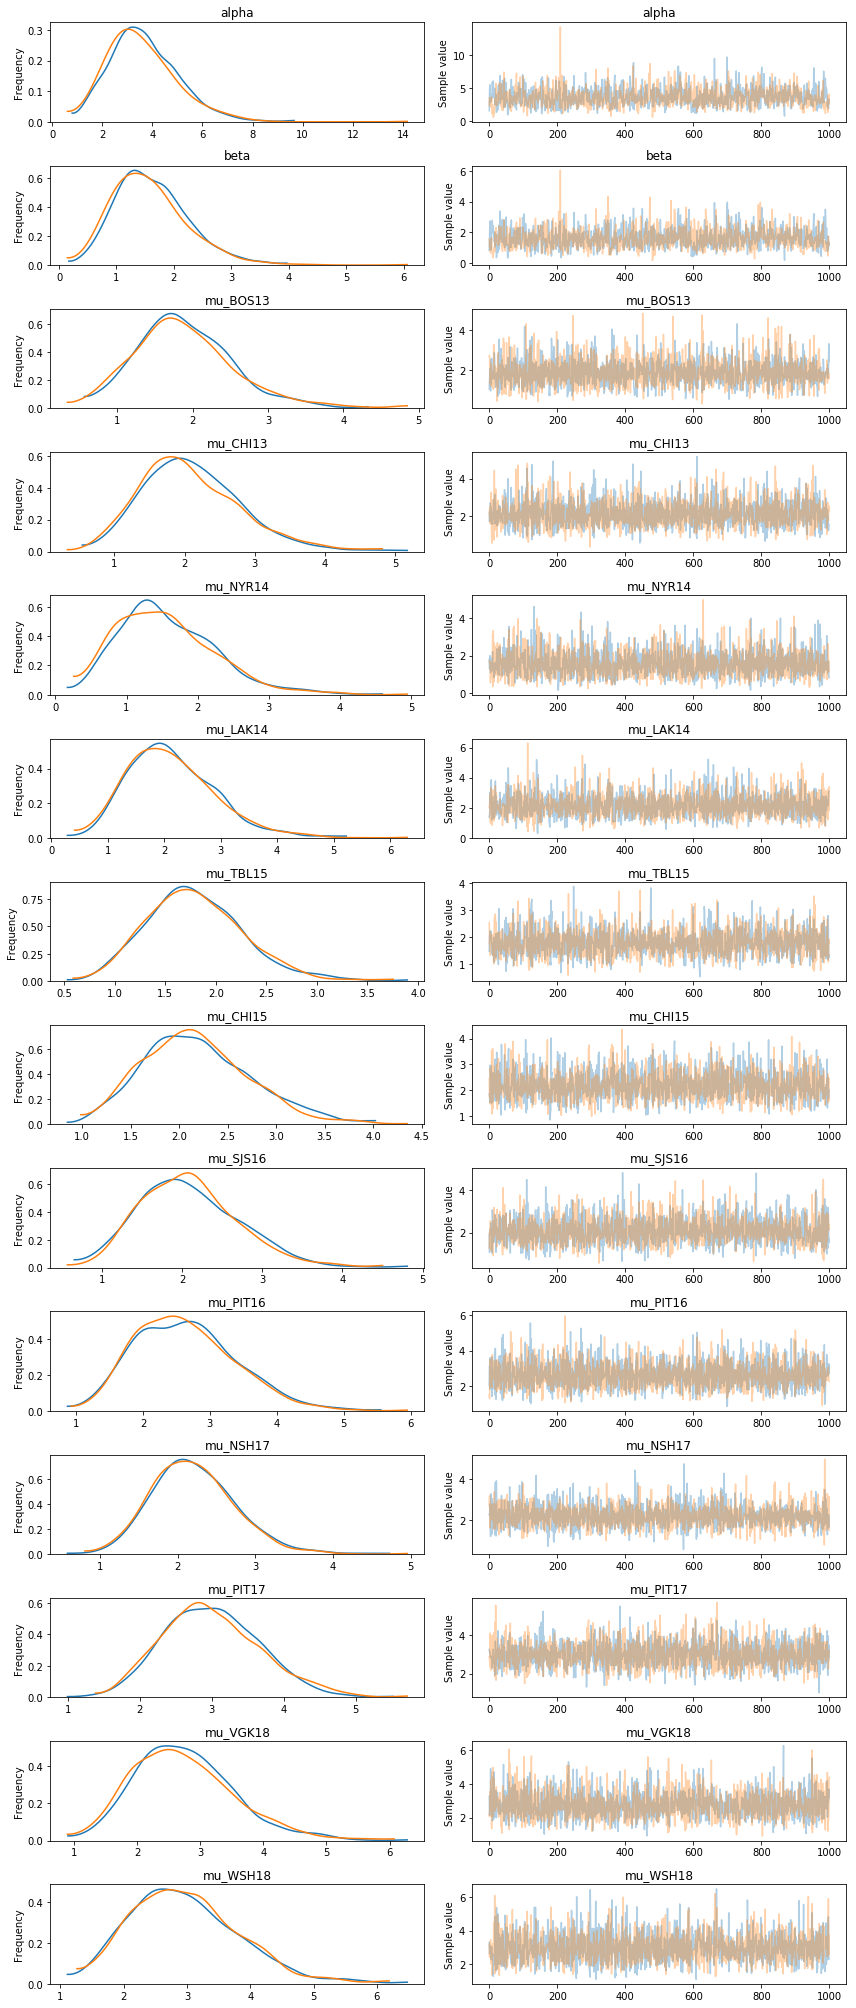

In [93]:
pm.traceplot(trace);

Here are the posterior means.

In [94]:
sample_post_mu_VGK = trace['mu_VGK18']
np.mean(sample_post_mu_VGK)

2.738049580241473

In [95]:
sample_post_mu_WSH = trace['mu_WSH18']
np.mean(sample_post_mu_WSH)

2.9708625859213225

They are lower with the background information than without, and closer together.  Here's the updated chance that Vegas is the better team.

In [96]:
np.mean(sample_post_mu_VGK > sample_post_mu_WSH)

0.427

## Predictions

Even if Vegas is the better team, that doesn't mean they'll win the next game.

We can use `sample_ppc` to generate predictions.

In [97]:
with model:
    post_pred = pm.sample_ppc(trace, samples=1000)

100%|██████████| 1000/1000 [00:02<00:00, 357.01it/s]


Here are the posterior predictive distributions of goals scored.

In [98]:
WSH = post_pred['WSH18']
WSH.shape

(1000, 3)

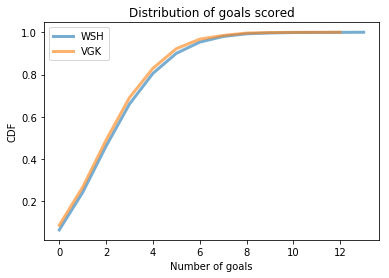

In [99]:
WSH = post_pred['WSH18'].flatten()
VGK = post_pred['VGK18'].flatten()

plot_cdf(WSH, label='WSH')
plot_cdf(VGK, label='VGK')
cdf_goals()

Here's the chance that Vegas wins the next game.

In [100]:
win = np.mean(VGK > WSH)
win

0.39666666666666667

The chance that they lose.

In [101]:
lose = np.mean(WSH > VGK)
lose

0.44766666666666666

And the chance of a tie.

In [102]:
tie = np.mean(WSH == VGK)
tie

0.15566666666666668

## Overtime!

In the playoffs, you play overtime periods until someone scores.  No stupid shootouts!

In a Poisson process with rate parameter `mu`, the time until the next event is exponential with parameter `lam = 1/mu`.

So we can take a sample from the posterior distributions of `mu`:

In [103]:
mu_VGK = trace['mu_VGK18']
mu_WSH = trace['mu_WSH18']

array([3.29949623, 2.62837258, 3.09365202, ..., 5.89303007, 2.55362515,
       3.71164352])

And generate time to score,`tts`, for each team:

In [104]:
tts_VGK  = np.random.exponential(1/mu_VGK)
np.mean(tts_VGK)

0.40026273454485134

In [105]:
tts_WSH  = np.random.exponential(1/mu_WSH)
np.mean(tts_WSH)

0.3569742547883298

Here's the chance that Vegas wins in overtime.

In [106]:
win_ot = np.mean(tts_VGK < tts_WSH)
win_ot

0.4855

Since `tts` is continuous, ties are unlikely.

In [107]:
total_win = win + tie * win_ot
total_win

0.47224283333333333

Finally, we can simulate the rest of the series and compute the probability that Vegas wins the series.

In [108]:
def flip(p):
    """Simulate a single game."""
    return np.random.random() < p

In [109]:
def series(wins, losses, p_win):
    """Simulate a series.
    
    wins: number of wins so far
    losses: number of losses so far
    p_win: probability that the team of interest wins a game
    
    returns: boolean, whether the team of interest wins the series
    """
    while True:
        if flip(p_win):
            wins += 1
        else:
            losses += 1

        if wins==4:
            return True

        if losses==4:
            return False

In [110]:
series(1, 2, total_win)

True

In [111]:
t = [series(1, 2, total_win) for i in range(1000)]
np.mean(t)

0.294